In [1]:
import numpy as np
import cv2

from scipy.stats import mode
from scipy.optimize import curve_fit
from scipy.io import loadmat
from ImageProcessing import *

import numpy as np
import matplotlib.pyplot as plt 

from ImageProcessing import *
from ImageGenerator import ImageGenerator

from sklearn.mixture import GaussianMixture

# Loading Data

In [2]:
path = '/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 30ms/'
filename = 'camera,fIdx=3354844,bx0_V=-0.068000000,by0_V=-0.230000000,bz0_V=0.020000000,imagingDetuning0_MHz=-0.600000000,cameraExposureTime=0.030000000,iterator=24.000000000.mat'
data = loadmat(path + filename)
n_loops = 20
lattice_shape = np.array([10, 10])
stack = data['stack']

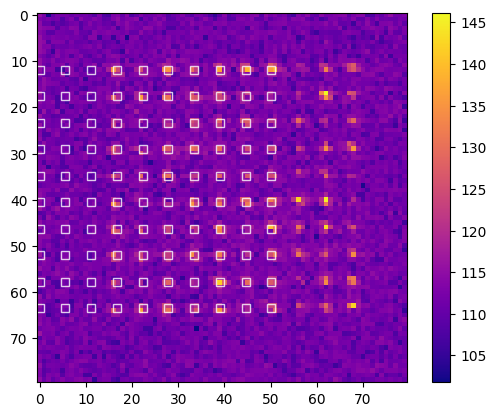

In [201]:
processor = GreenImageProcessor(stack, lattice_shape, 20)
processor.plot()

In [90]:
crops = processor.crop_sites(1)
crop = np.mean(crops, axis=(1,2)).flatten()
counts, bins = np.histogram(crop, bins=(processor.per_loop // 4))
centers = (bins[:-1] + bins[1:]) / 2

# Playing with Scikit's mixed gaussian model fitting

In [91]:
tot = np.sum(crop)
mix = GaussianMixture(2)
mix.fit(np.reshape(crop, (crop.shape[0], 1)))
means = mix.means_.flatten()
weights = mix.weights_.flatten()
std = np.sqrt(mix.covariances_.flatten())
print(tot)

50238436.58333334


[6.00883442e-06 1.80265033e-05 1.20176688e-05 4.80706753e-05
 1.14167854e-04 3.06450555e-04 5.64830435e-04 1.41808492e-03
 2.87222285e-03 6.74792105e-03 1.55268281e-02 2.79591065e-02
 5.08587745e-02 8.40035052e-02 1.24412917e-01 1.84861791e-01
 2.08332298e-01 2.34044101e-01 2.39998855e-01 2.23390437e-01
 2.03074568e-01 1.47258505e-01 1.11499931e-01 8.06806197e-02
 5.98720261e-02 5.15497905e-02 4.46035779e-02 4.57031946e-02
 4.94767426e-02 5.20485237e-02 6.03527329e-02 5.70358563e-02
 5.75766514e-02 5.35507323e-02 4.81187460e-02 4.57452564e-02
 3.61912097e-02 3.01703576e-02 2.36627899e-02 1.84891835e-02
 1.50160772e-02 9.80641777e-03 7.00630093e-03 4.78303220e-03
 3.29284126e-03 2.23528640e-03 1.52624394e-03 8.65272156e-04
 5.58821601e-04 3.24477059e-04 1.92282701e-04 1.44212026e-04
 4.80706753e-05 3.00441721e-05 1.20176688e-05 1.20176688e-05]


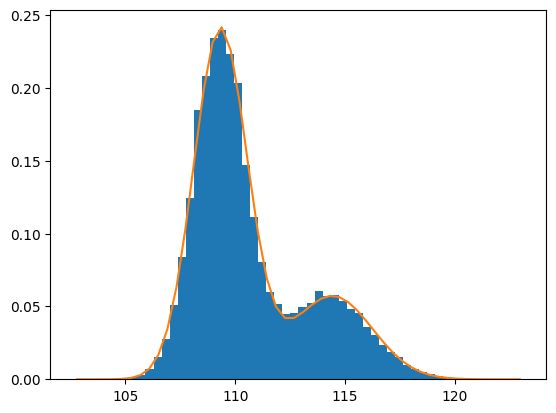

In [92]:
counts, bins, _ = plt.hist(crop, bins=(processor.per_loop  // 4), density=True)
x = np.linspace(centers[0], centers[-1])
print(counts)
#print(weights)
#print(gaussian(x, means[0], std[0], weights[0]))
plt.plot(x, 0.398942280401 * (gaussian(x, means[0], std[0], weights[0]) / std[0] + gaussian(x, means[1], std[1], weights[1] / std[1])))

# Fixing anomolous bright/dark thresholding

In [93]:
upper_thresh = 7
lower_thresh = 3
arr = np.array([8, 11, 11, 9, 8, 11, 9, 5, 2, 3, 2, 1, 3, 4, 5, 11, 10, 11, 10, 10])
over_thresh = np.arange(arr.size)[arr >= upper_thresh]
under_thresh = np.arange(arr.size)[arr <= lower_thresh]
labels = np.empty(arr.size)
print(over_thresh)
print(under_thresh)

[ 0  1  2  3  4  5  6 15 16 17 18 19]
[ 8  9 10 11 12]


In [94]:
def slicer(arr, upper_thresh, lower_thresh, labels):
    head = tail = 0
    bright = True
    for i, val in enumerate(arr):
        if val >= upper_thresh and bright:
            head = i + 1
        elif val >= upper_thresh and not bright:
            labels[head:i] = np.full(i - head - 1, np.NaN)
            labels[tail:head] = np.zeros(head - tail)
            tail = i
            head = i + 1
            bright = True
        elif val <= lower_thresh and not bright:
            head = i + 1
        elif val <= lower_thresh and bright:
            labels[head:i] = np.full(i - head, np.NaN)
            labels[tail:head] = np.ones(head - tail)
            tail = i
            head = i + 1
            bright = False
    if bright:
        labels[tail:head] = np.ones(head - tail)
        labels[head:] = np.full(labels.size - head, np.NaN)
    else:
        labels[head:] = np.zeros(labels.size - head)


In [95]:
slicer(arr, upper_thresh, lower_thresh, labels)
print(labels)

[ 1.  1.  1.  1.  1.  1.  1. nan  0.  0.  0.  0.  0. nan nan  1.  1.  1.
  1.  1.]


# Playing with openCV for site detection

In [7]:
def fractional_stack(stack, n_loops, n):
    # Given the stack and an integer n, slice the first 1 / n images from the stack and return the averaged images across this set
    per_loop = stack.shape[0] // n_loops
    slices = np.empty((n_loops, *stack.shape[1:]))
    for i in range(n_loops):
        slice_size = per_loop // n
        slices[i] = np.mean(stack[i * per_loop: i * per_loop + slice_size], axis=0)
    return slices

In [701]:
img_width, img_height = stack.shape[1:]
n_loops = 20
per_loop = stack.shape[0] // n_loops
img = np.mean(fractional_stack(stack, 20, 8), axis=0)
img = img.astype(np.uint8)

In [4]:
def method0(img, n_tweezers):
    img = np.copy(img)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    model = GaussianMixture(2)
    model.fit(np.reshape(img.flatten(), (img.size, 1)))
    std = np.sqrt(model.covariances_.flatten())
    thresh = -2.32 * std.min()
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, thresh)
    n_sites, labeled_img, stats, centroids = cv2.connectedComponentsWithStats(img)
    centroids = centroids[np.argsort(stats[:,-1])]
    plt.imshow(img)
    return centroids[-2:-n_tweezers - 2:-1]

def method1(img, n_tweezers):
    img = np.copy(img)
    model = GaussianMixture(2)
    model.fit(np.reshape(img.flatten(), (img.size, 1)))
    std = np.sqrt(model.covariances_.flatten())
    thresh = -2.32 * std.min()
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, thresh)
    n_sites, labeled_img, stats, centroids = cv2.connectedComponentsWithStats(img)
    centroids = centroids[np.argsort(stats[:,-1])]
    plt.imshow(img)
    return centroids[-2:-n_tweezers - 2:-1]

def method2(img, n_tweezers):
    img = np.copy(img)
    thresh, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    n_sites, labeled_img, stats, centroids = cv2.connectedComponentsWithStats(img)
    centroids = centroids[np.argsort(stats[:,-1])]
    plt.imshow(img)
    return centroids[-2:-n_tweezers - 2:-1]

def method3(img, n_tweezers, r=2):
    img = np.copy(img)
    positions = []
    dilate = cv2.dilate(img, None)
    matching = np.where(dilate == img, img, -255)
    i = 0
    d = 2 * r + 1
    while i < n_tweezers:
        pos = np.unravel_index(np.argmax(matching), img.shape)
        if any(i == 0 for i in pos) or (matching[pos[0] - 1: pos[0] + 1, pos[1] - 1: pos[1] + 1] == 0).any():
            matching[pos] = -255
        else:
            matching[pos[0] - r: pos[0] + r + 1, pos[1] - r: pos[1] + r + 1] = np.zeros((d, d))
            positions.append(pos)
            i += 1
    plt.imshow(matching)
    return np.array(positions)[:,::-1]


NameError: name 'img' is not defined

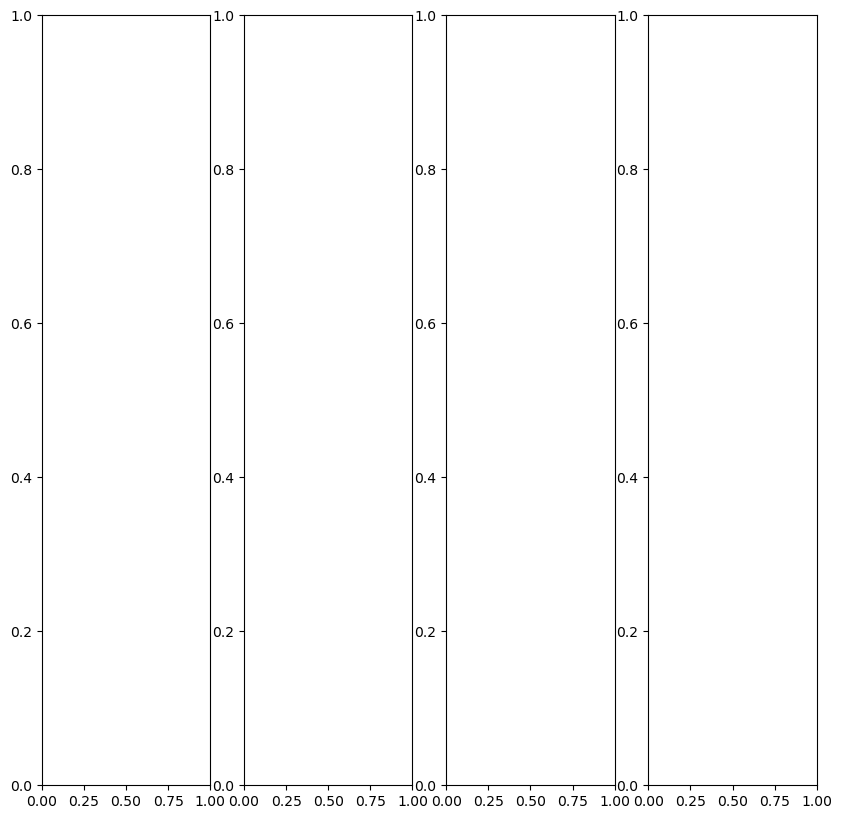

In [5]:
methods = [method0, method1, method2, method3]
n_tweezers = 100

fig, axs = plt.subplots(1, len(methods), figsize=(10, 10))

for i in range(len(methods)):
    centroids = methods[i](img, n_tweezers)
    axs[i].imshow(img)
    axs[i].plot(*centroids.T, 'r.')
    axs[i].set_title(f"Method {i}")



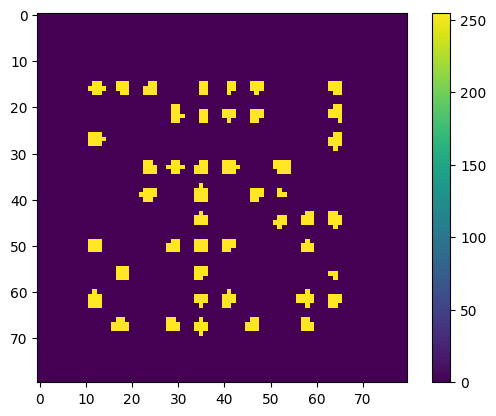

In [704]:
frac_stack = fractional_stack(stack, 20, 8)
i = 4
img = frac_stack[i].astype('uint8')
img = np.copy(img)
img = cv2.GaussianBlur(img, (3, 3), 0)
model = GaussianMixture(2)
model.fit(np.reshape(img.flatten(), (img.size, 1)))
std = np.sqrt(model.covariances_.flatten())
thresh = -2.32 * std.min()
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, thresh)
n_sites, labeled_img, stats, centroids = cv2.connectedComponentsWithStats(img)
for stat in stats:
    if stat[-1] <= 2:
        img[stat[1]:stat[1] + stat[3], stat[0]:stat[0] + stat[2]] = np.zeros((stat[3], stat[2]))
plt.imshow(img)
plt.colorbar()

In [8]:
def find_positions(stack, n_tweezers, n_loops, keep_borders=False):
    frac_stack = fractional_stack(stack, n_loops, 8)
    final = np.zeros(frac_stack.shape[1:], dtype='uint8')
    for img in frac_stack:
        img = np.copy(img).astype('uint8')
        img = cv2.GaussianBlur(img, (3, 3), 0)
        model = GaussianMixture(2)
        model.fit(np.reshape(img.flatten(), (img.size, 1)))
        std = np.sqrt(model.covariances_.flatten())
        thresh = -4 * np.maximum(std.min(), 0.6)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, thresh)
        n_sites, labeled_img, stats, centroids = cv2.connectedComponentsWithStats(img)
        for stat in stats:
            if stat[-1] <= 2:
                img[stat[1]:stat[1] + stat[3], stat[0]:stat[0] + stat[2]] = np.zeros((stat[3], stat[2]))
        final = np.maximum(img, final)
    plt.imshow(final)
    n_sites, labeled_img, stats, centroids = cv2.connectedComponentsWithStats(final)
    centroids = centroids[np.argsort(stats[:,-1])]
    return centroids[-2:-n_tweezers - 2:-1]

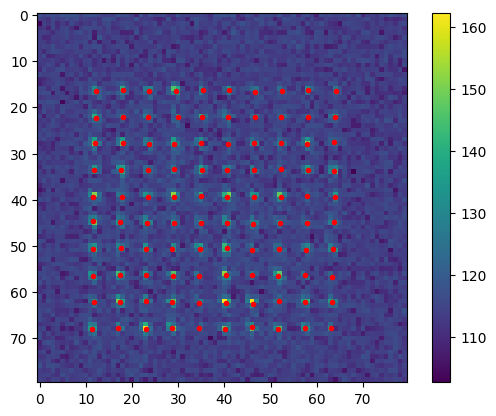

In [9]:
centroids = find_positions(stack, 100, 20)
plt.imshow(np.mean(stack, axis=0))
plt.plot(*centroids.T, 'r.')
plt.colorbar()

# Nearest neighbor distance function

In [26]:
import numpy as np
def brute_force_closest_pair(points):
    # Brute-force method to calculate the minimum distance between vectors
    min_distance = np.inf
    closest_pair = (None, None)
    for i in range(len(points) - 1):
        for j in range(i + 1, len(points)):
            dist = np.linalg.norm(points[i] - points[j])
            if dist < min_distance:
                min_distance = dist
                closest_pair = (points[i], points[j])
    return min_distance, closest_pair

def closest_pair_distance(points):
    if len(points) <= 3:
        return brute_force_closest_pair(points)
    points = points[points[:, 0].argsort()]
    mid_point = len(points) // 2
    left_points = points[:mid_point]
    right_points = points[mid_point:]
    min_dist_left, closest_left = closest_pair_distance(left_points)
    min_dist_right, closest_right = closest_pair_distance(right_points)
    if min_dist_left < min_dist_right:
        min_distance = min_dist_left
        closest_pair = closest_left
    else:
        min_distance = min_dist_right
        closest_pair = closest_right
    strip_points = points[np.abs(points[:, 0] - points[mid_point, 0]) < min_distance]
    strip_points = strip_points[strip_points[:, 1].argsort()]
    min_dist_strip = min_distance
    closest_strip = (None, None)
    for i in range(len(strip_points)):
        j = i + 1
        while j < len(strip_points) and strip_points[j, 1] - strip_points[i, 1] < min_dist_strip:
            dist = np.linalg.norm(strip_points[i] - strip_points[j])
            if dist < min_dist_strip:
                min_dist_strip = dist
                closest_strip = (strip_points[i], strip_points[j])
            j += 1
    if min_dist_strip < min_distance:
        return min_dist_strip, closest_strip
    else:
        return min_distance, closest_pair


# Example usage:
vectors = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
min_distance, closest_pair = closest_pair_distance(centroids)
print(f"Minimum L2 distance: {min_distance}")
print(f"Closest pair of vectors: {closest_pair}")
print(np.diff(closest_pair, axis=0))


Minimum L2 distance: 5.180610072167144
Closest pair of vectors: (array([46.15384615, 62.46153846]), array([45.90909091, 67.63636364]))
[[-0.24475524  5.17482517]]
